# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [ ]:
if os.path.exists('/content/data'):
  shutil.rmtree('/content/data')

os.mkdir('/content/data')
!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O /content/data/data.zip
!unzip "/content/data/data.zip" -d "/content/"
os.system("rm /content/data/data.zip")
data_dir = '/content/data/'


--2024-11-26 01:54:23--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 172.217.12.14, 2607:f8b0:4025:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2024-11-26 01:54:23--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.0.65, 2607:f8b0:4025:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘/content/data/data.zip’

/content/data/data. 100%[===================>]   5.92M  --.-KB/s    in 0.1s 

Utils Functions.

In [ ]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

Referring to Fig 2a, $\vec{l}$ is the incident direction of the source, $\vec{n}$ is the normal direction of the surface patch, and $\vec{v}$ is the viewing direction.

The dot product comes from the fact that for a Lambertian surface, the amount of light received by an infinitesimal patch $dA$ is proportional to the incident source multiplied by $cos(\theta)$, where $\theta$ is the angle between $\vec{l}$ and $\vec{n}$. By definition of the cosine, this equals to $\vec{l} \cdot \vec{n}$.

Referring to Fig. 2b, when we shine a light source onto the original area from an angle $\theta$ to the surface normal, only the light in the light cone of the projected area is projected onto the surface (i.e. the flux received by the original area is equal to the flux received by the projected area). Since the flux is spread over a larger area, the intensity decreases proportional to the ratio of the 2 areas, which turns out to equal $cos(\theta)$. I.e., the light particles hitting the original area $dA$ is equivalent to the light particles hitting the projected area $cos(\theta)dA$. We get their intensities by dividing by $dA$ to leave us their intensities are proportional by $cos(\theta)$. We can then map $cos(\theta)$ to $\vec{l} \cdot \vec{n}$ from the paragraph above.

The viewing direction does not matter since we are assuming the object is Lambertian. This means the bidirectional reflectance distribution function is a constant (i.e. its albedo is the same) and the surface appears equally bright from all directions. This is a reasonable assumption for diffuse/body reflections where light ways bounce back with no preferential direction.

---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

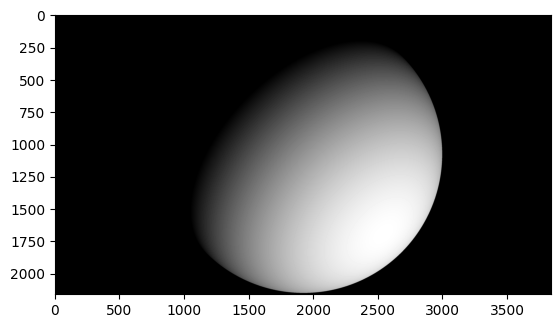

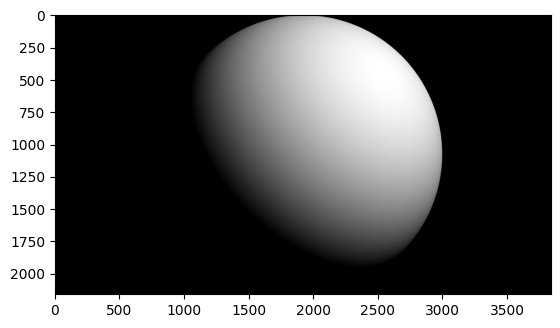

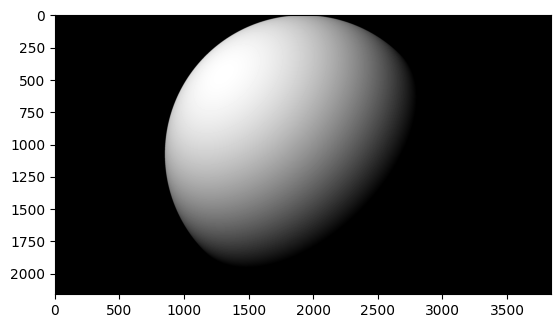

In [ ]:
def renderNDotLSphere(center, rad, light, pxSize, res):

    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """

    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize*1.e-4
    Y = (Y - res[1]/2) * pxSize*1.e-4
    Z = np.sqrt(rad**2+0j-X**2-Y**2)
    X[np.real(Z) == 0] = 0
    Y[np.real(Z) == 0] = 0
    Z = np.real(Z)

    image = None
    ### YOUR CODE HERE

    # Compute surface normals
    normals = np.stack((X, Y, Z), axis=-1)
    norm_mag = np.linalg.norm(normals, axis=-1, keepdims=True)
    normals = np.divide(normals, norm_mag, where=(norm_mag != 0))

    # Compute surface radiance
    albedo = 1
    radiance = albedo * np.sum(normals * light, axis=-1)
    radiance = np.maximum(0, radiance)

    image = radiance

    ### END YOUR CODE

    return image

# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


In [ ]:
### YOUR CODE HERE
U, S, VT = np.linalg.svd(I, full_matrices=False)

print("Singular values of I:", S)
### END YOUR CODE

Singular values of I: [79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]



---

$I=L^TB$ describes the relationship between the lighting directions (L), the pseudonormals (B), and intensity measurements (I). The lighting direction is a $3\times 7$ matrix as each light direction has 3 degrees of freedom corresponding to its direction and intensity. Similarly, the pseudonormals is a $3\times P$ matrix and also has 3 degrees of freedom (1 DOF for albedo, 2 DOF for normalized unit direction). Since $I$ is a matrix multiplication of two matricies what have at most 3 DOF, the DOF of $I$ (and thus its rank) is also limited to be theoretically at most 3. Another way to think about it is that we need 3 independent equations from solving $I=L^TB$ to recover the normals of the surface we're considering, thus there are 3 DOFs and the rank of $I$ should be 3.

The singular values of $I$ are displayed above. Theoretically, for a rank 3 matrix, only the first 3 singular values should be non-zero. From above, we see that this is not the case as all 7 entries are non-zero. This is presumably due to noise in the data, as no object can have perfect diffuse reflection and no specular reflection (i.e. it cannot be perfectly Lambertian). This introduces errors into the $I$ matrix. However, the first 3 values have magnitudes that are large compared to the last 4 values. So roughly, the $I$ matrix is of rank 3 if we neglect the last 4 smaller singular values (which are due to noise).

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [ ]:
def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    ### YOUR CODE HERE

    # Using Moore-Penrose pseudo-inverse
    L_pseudo_inverse = np.linalg.pinv(L.T)
    B = np.dot(L_pseudo_inverse, I)

    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)

---

For a linear system of the form **$Ax=y$**, we define the Moore-Penrose pseudo inverse as **$A'=(A^TA)^{-1}A^T$**. Multiplying the pseudo inverse on the left, we obtain:

$A'Ax=A'y$

$(A^TA)^{-1}A^TAx=A'y$

$x=A'y$

Mapping the above equation to $I=L^TB$ and contructing $y=I$, $A=L^T$ (so $A'=(LL^T)^{-1}L$), and $x=B$, we obtain the following:

$B=(LL^T)^{-1}LI$, where $A'=(LL^T)^{-1}L$ is the Moore-Penrose pseudo inverse of $L^T$.

Some nice properties of the Moore-Penrose pseudo inverse is that for our purposes, the inverse $(LL^T)^{-1}$ exists as long as $L$ has rank 3. This means that as long as all the lights are not lined up on the same 2D plane, then the Moore-Penrose pseudo inverse will exist and we can solve for $B$. Additionally, when the problem is over-paramatrized (such as the case when we have 7 light sources), the Moore-Penrose pseudo inverse will give the best fit least squares approximate solution.

Note: The equation is not very clear as to how to specify the linear system of the form **$Ax=y$**. We can also equivalently state the relationship as $y=B$, $x=I$, and $A=(LL^T)^{-1}L$. and solve directly the equation **$Ax=y$**. Moreover, another paramatrization could be $A=(LL^T)$, $x=B$, and $y=LI$, and we solve the linear system $x=A^{-1}y$.

---


### Q 1 (e) Albedos and normals (10 points)

---

For a Lambertian surface, we expect the albedo shading of the shape to be roughly similar. Looking at the albedo image, this is not the case under the nose, on the neck, under the eyelids, and in the earlobes where the shading is brighter (thus implying a higher albedo). For the earlobes and eyelids, a potential reason for the higher albedo could be due to the fact that the skin there is more translucent, thereby causing more light to be diffused rather than absorbed by the skin. For the nose and neck, a potential reason for the higher albedo could be due to inter-reflections from other parts of the face at the corner contours. This gives the impression that more light is being reflected at their locations (which violates the n-dot-l assumption that there are no inter-reflections).

As for the normals image, it matches my expectation of the curvature of the face. We see that two colors seperate at the vertical symmetry of the face, corresponding to normals which are pointing more leftward or pointing rightward. Additionally, on the relatively flat forehead, we see that the color is purpleish, which corresponds to a normal pointing out of the screen. Sharp color transitions at the edges (due to sudden changes in the normal vector) also trace out the locations of major features on the face (e.g. eyes, lips, nose, eyebrows, etc).

---

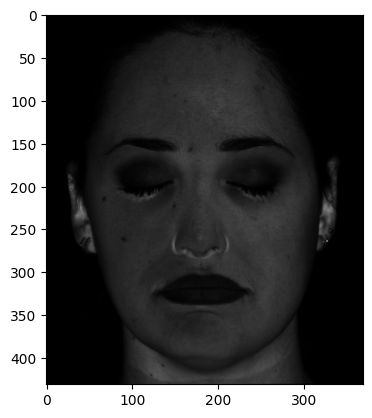

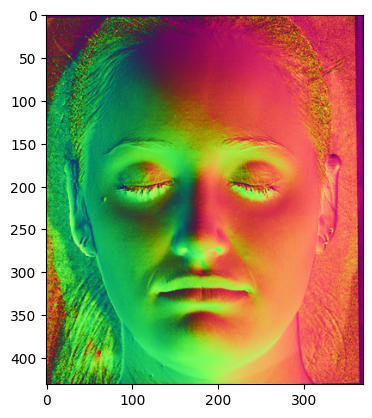

In [ ]:
def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None

    ### YOUR CODE HERE

    albedos = np.linalg.norm(B, axis=0)
    normals = B/albedos

    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---
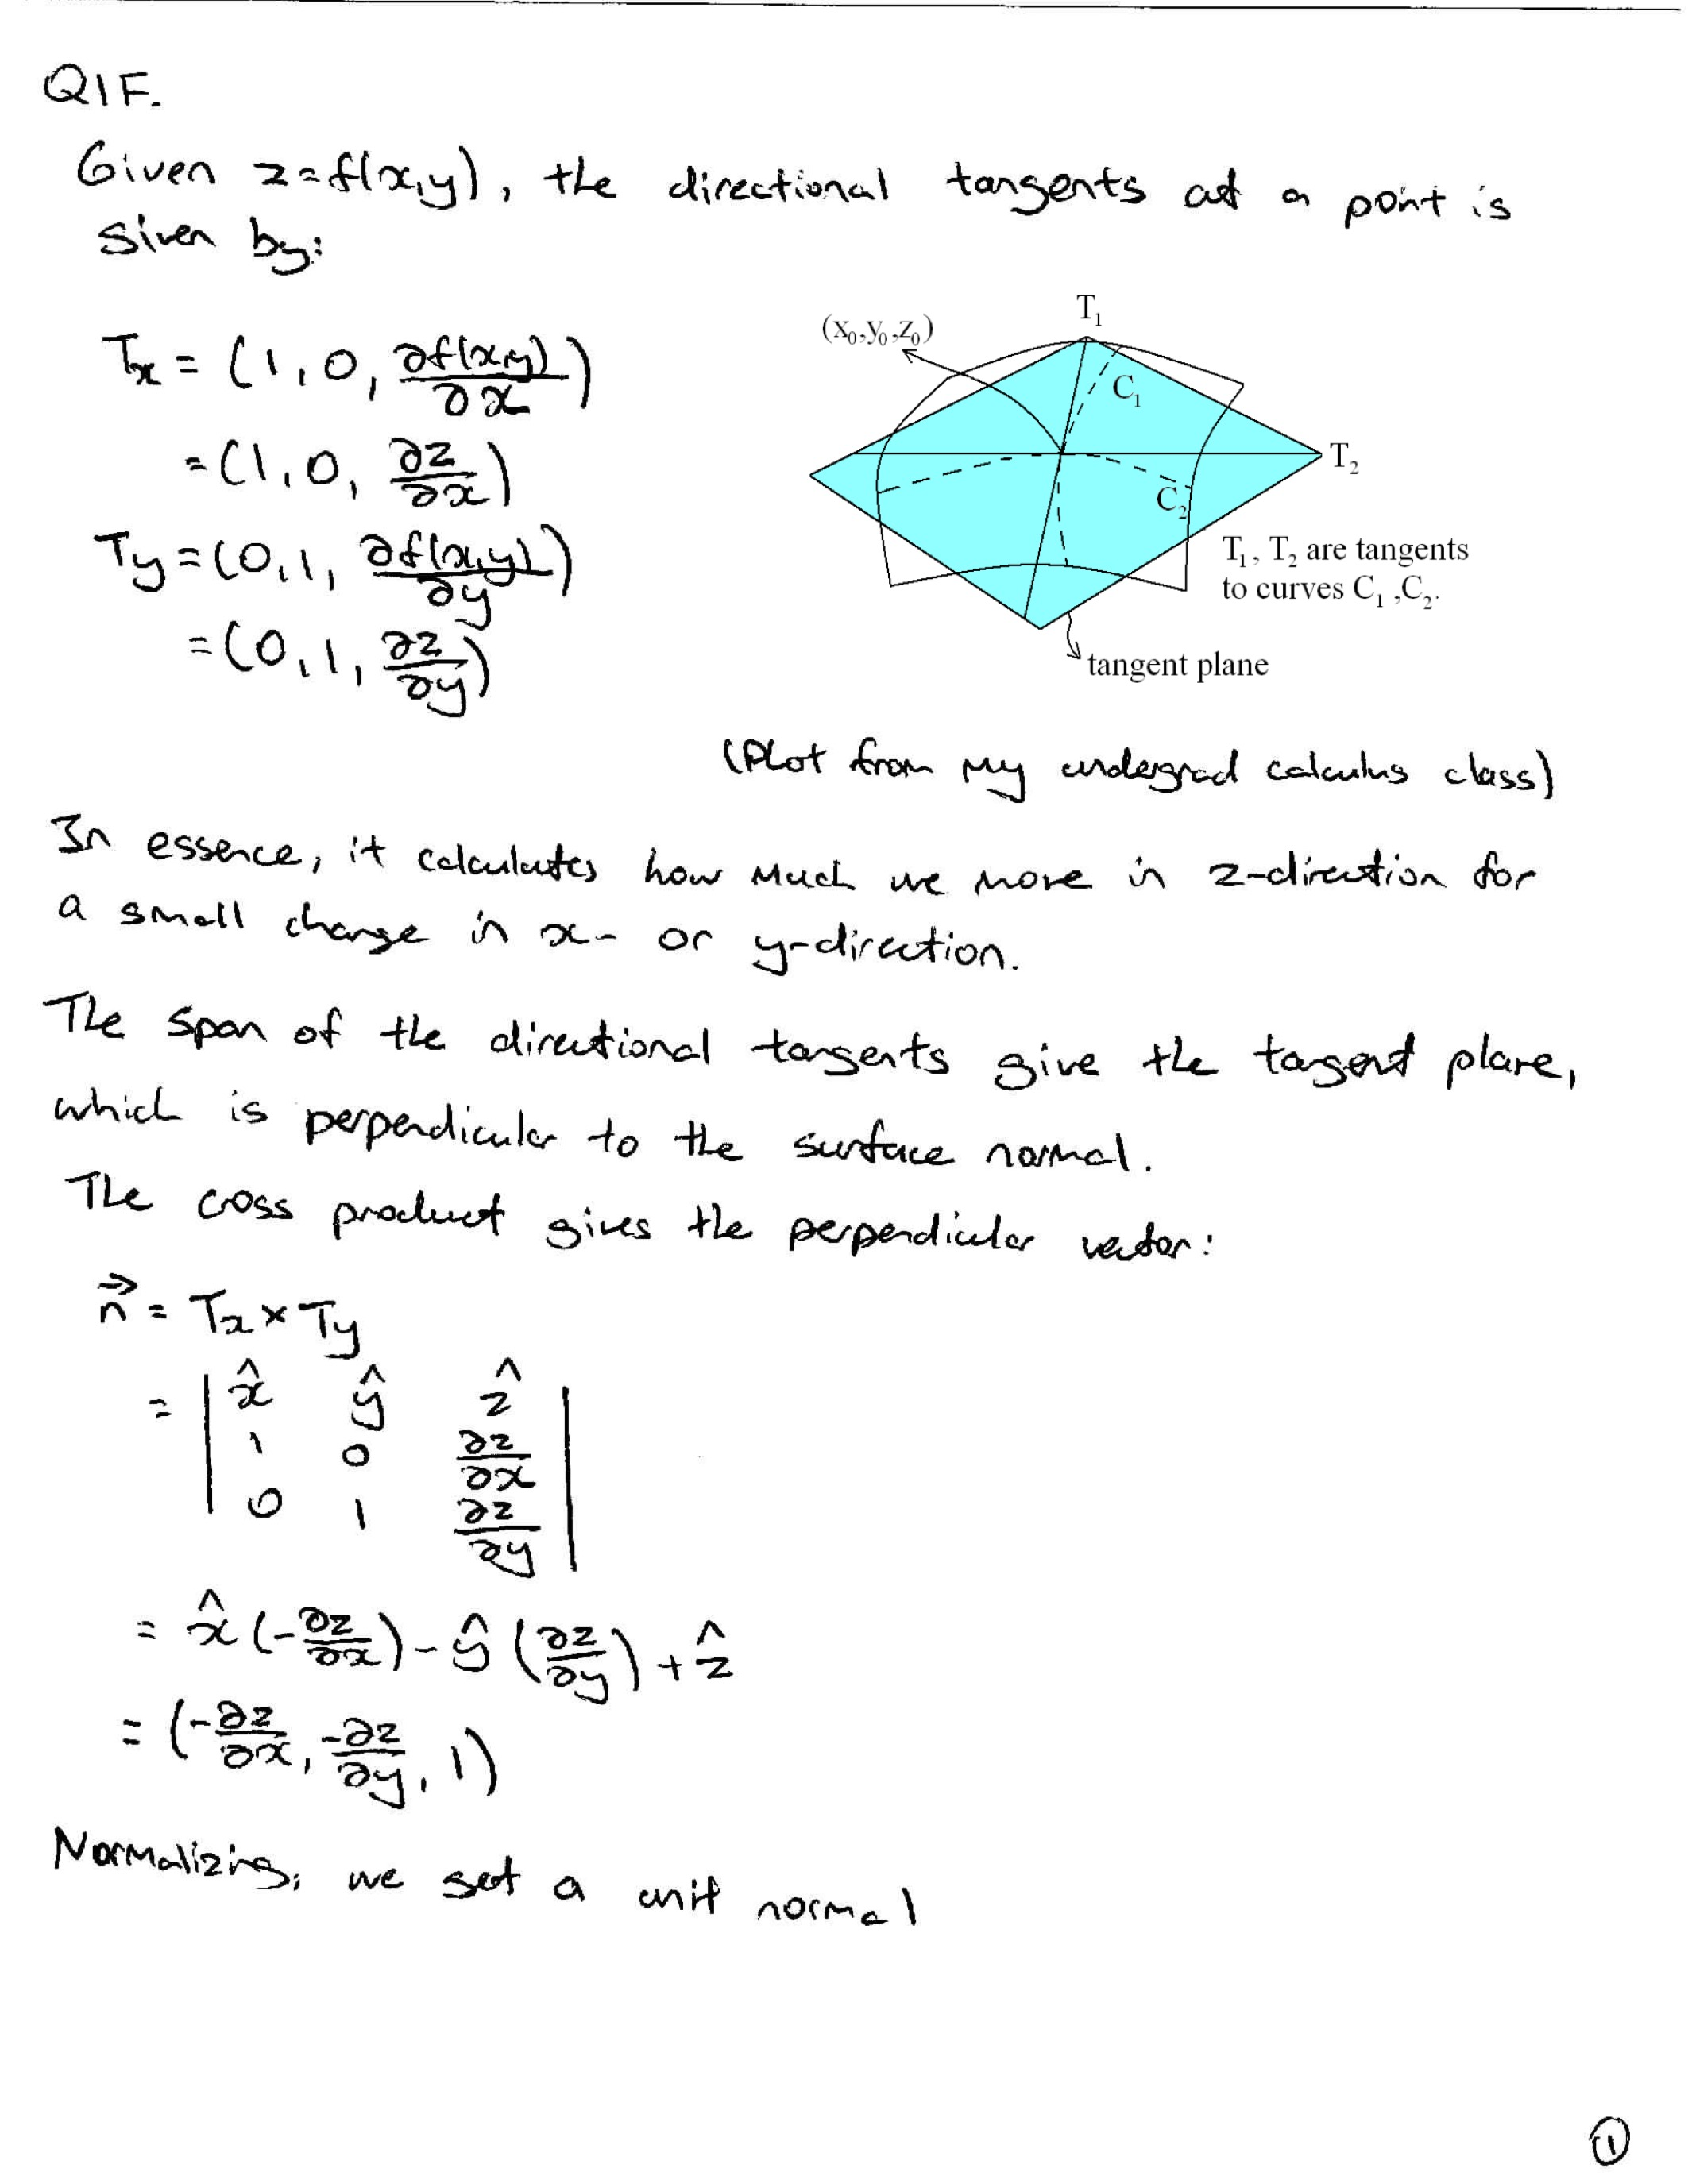

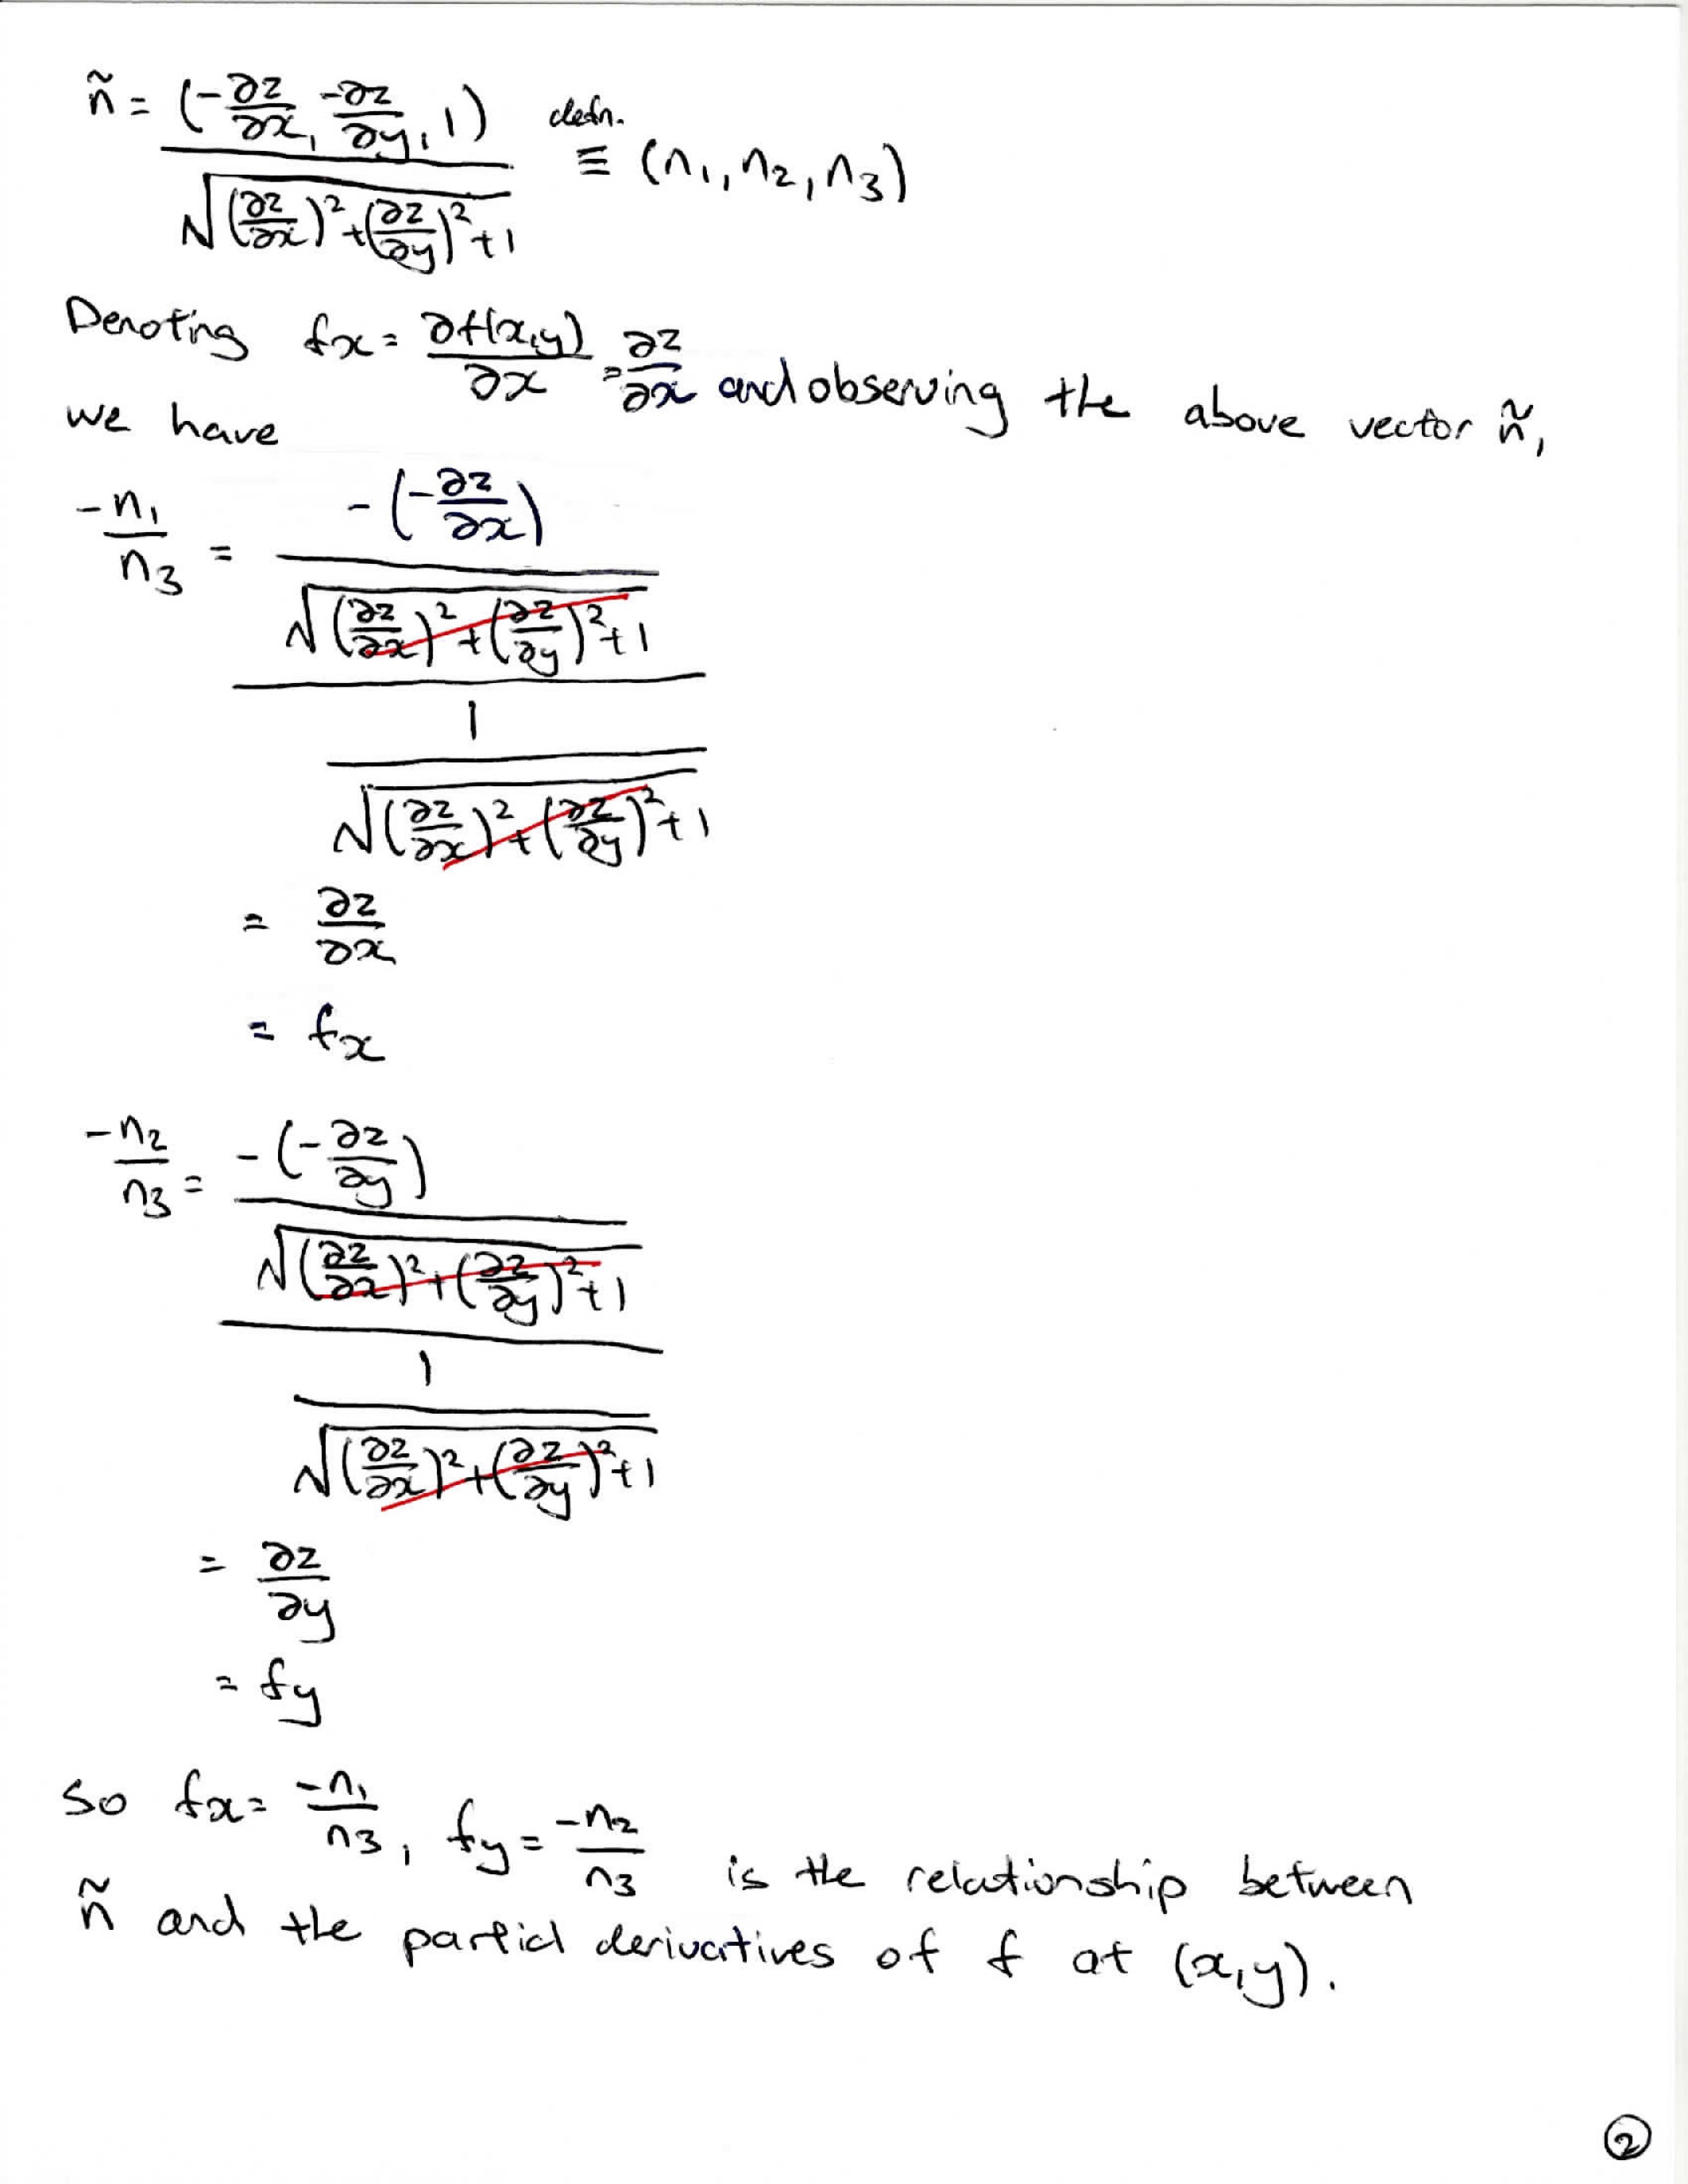
---

### Q 1 (g): Understanding integrability of gradients (5 points)

---

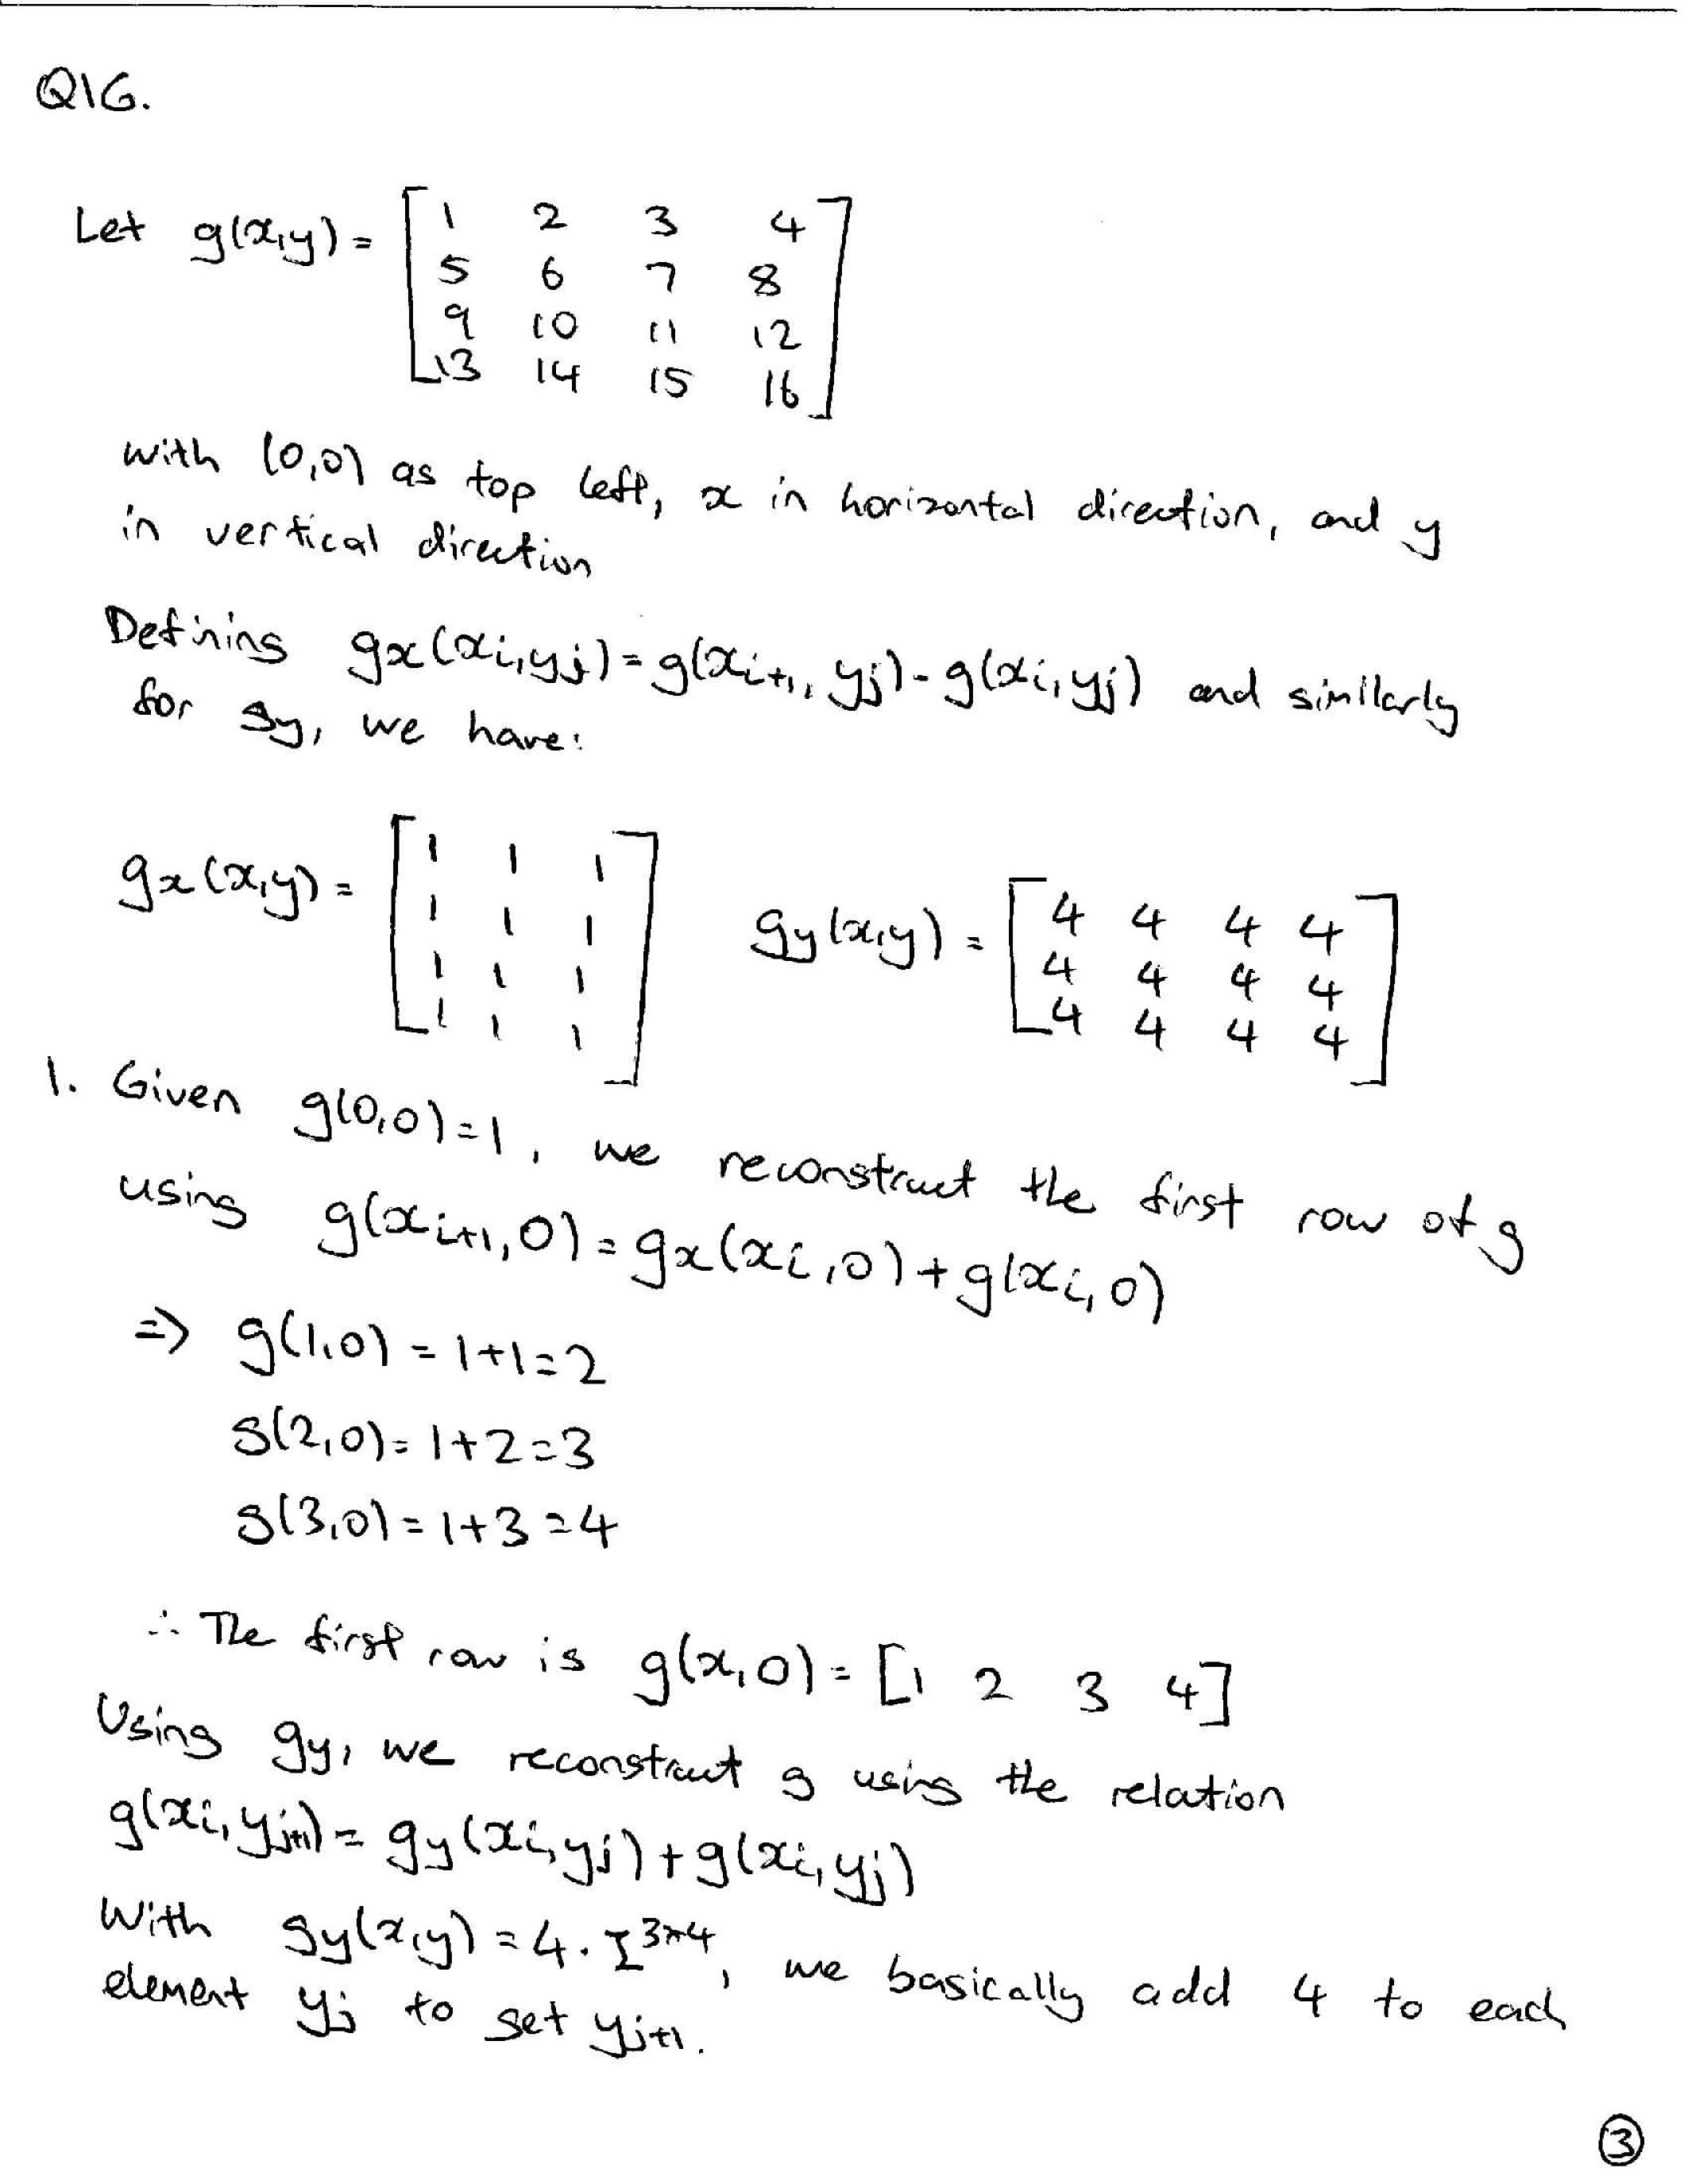

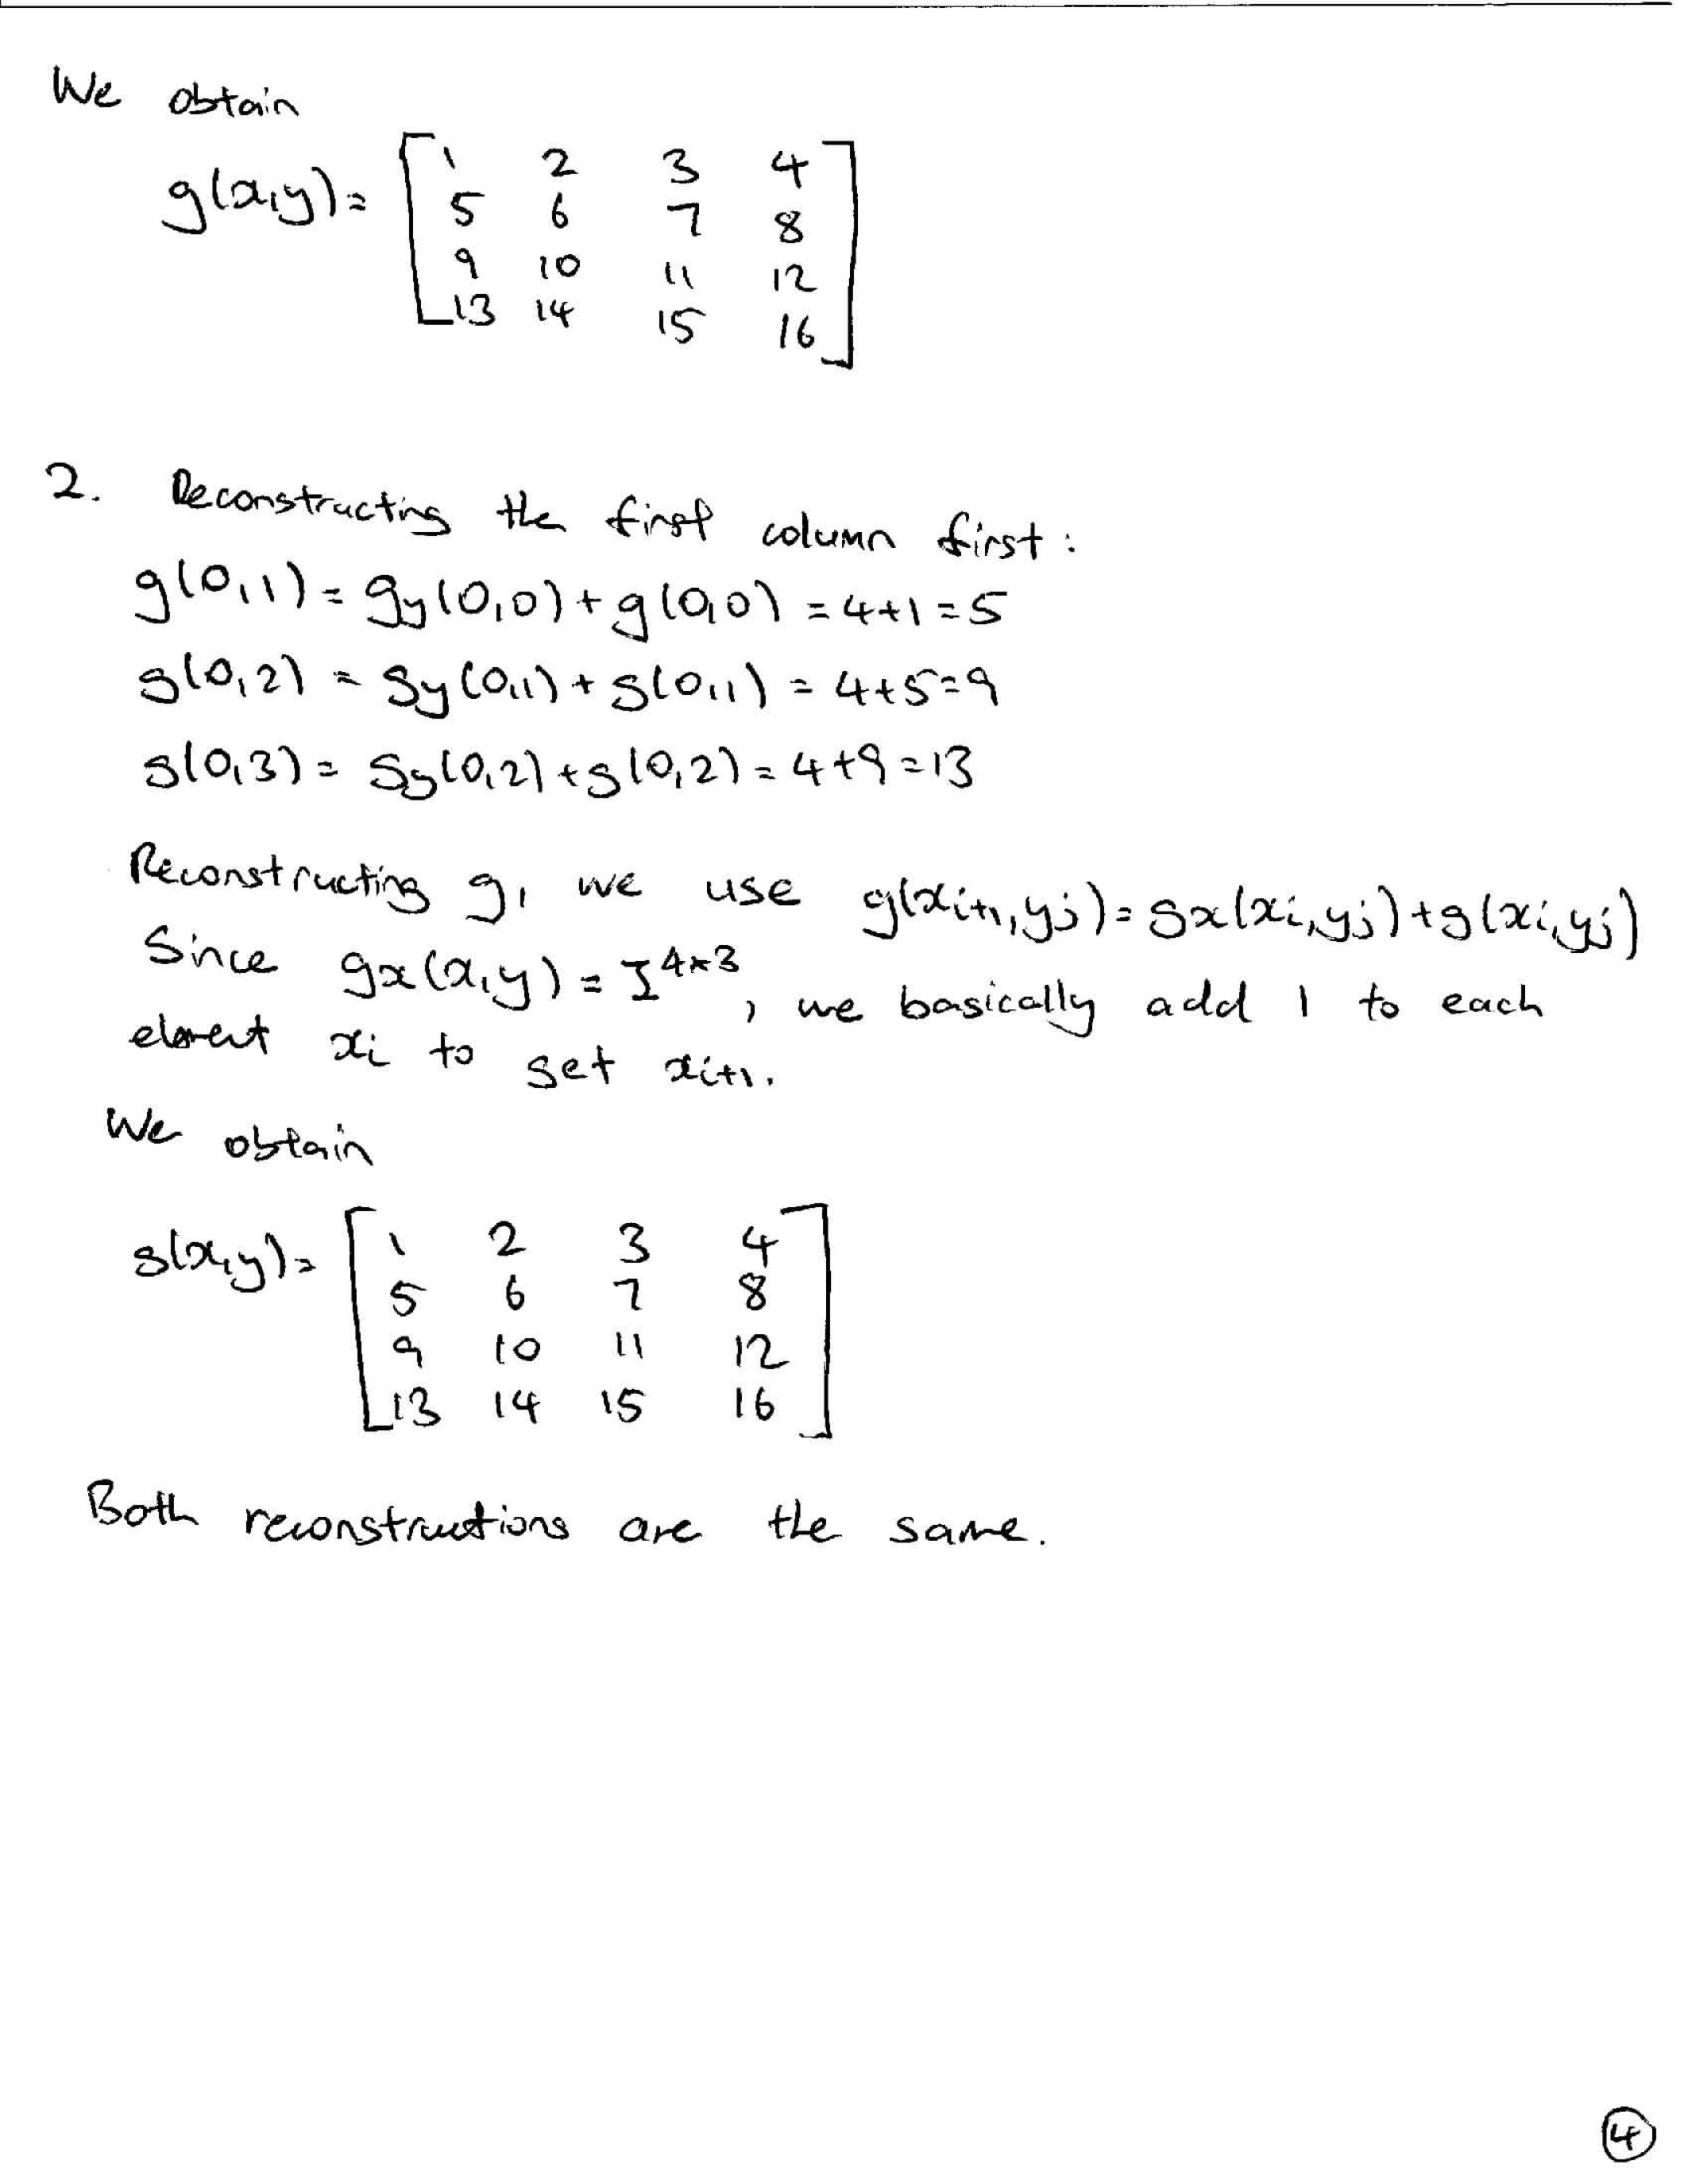

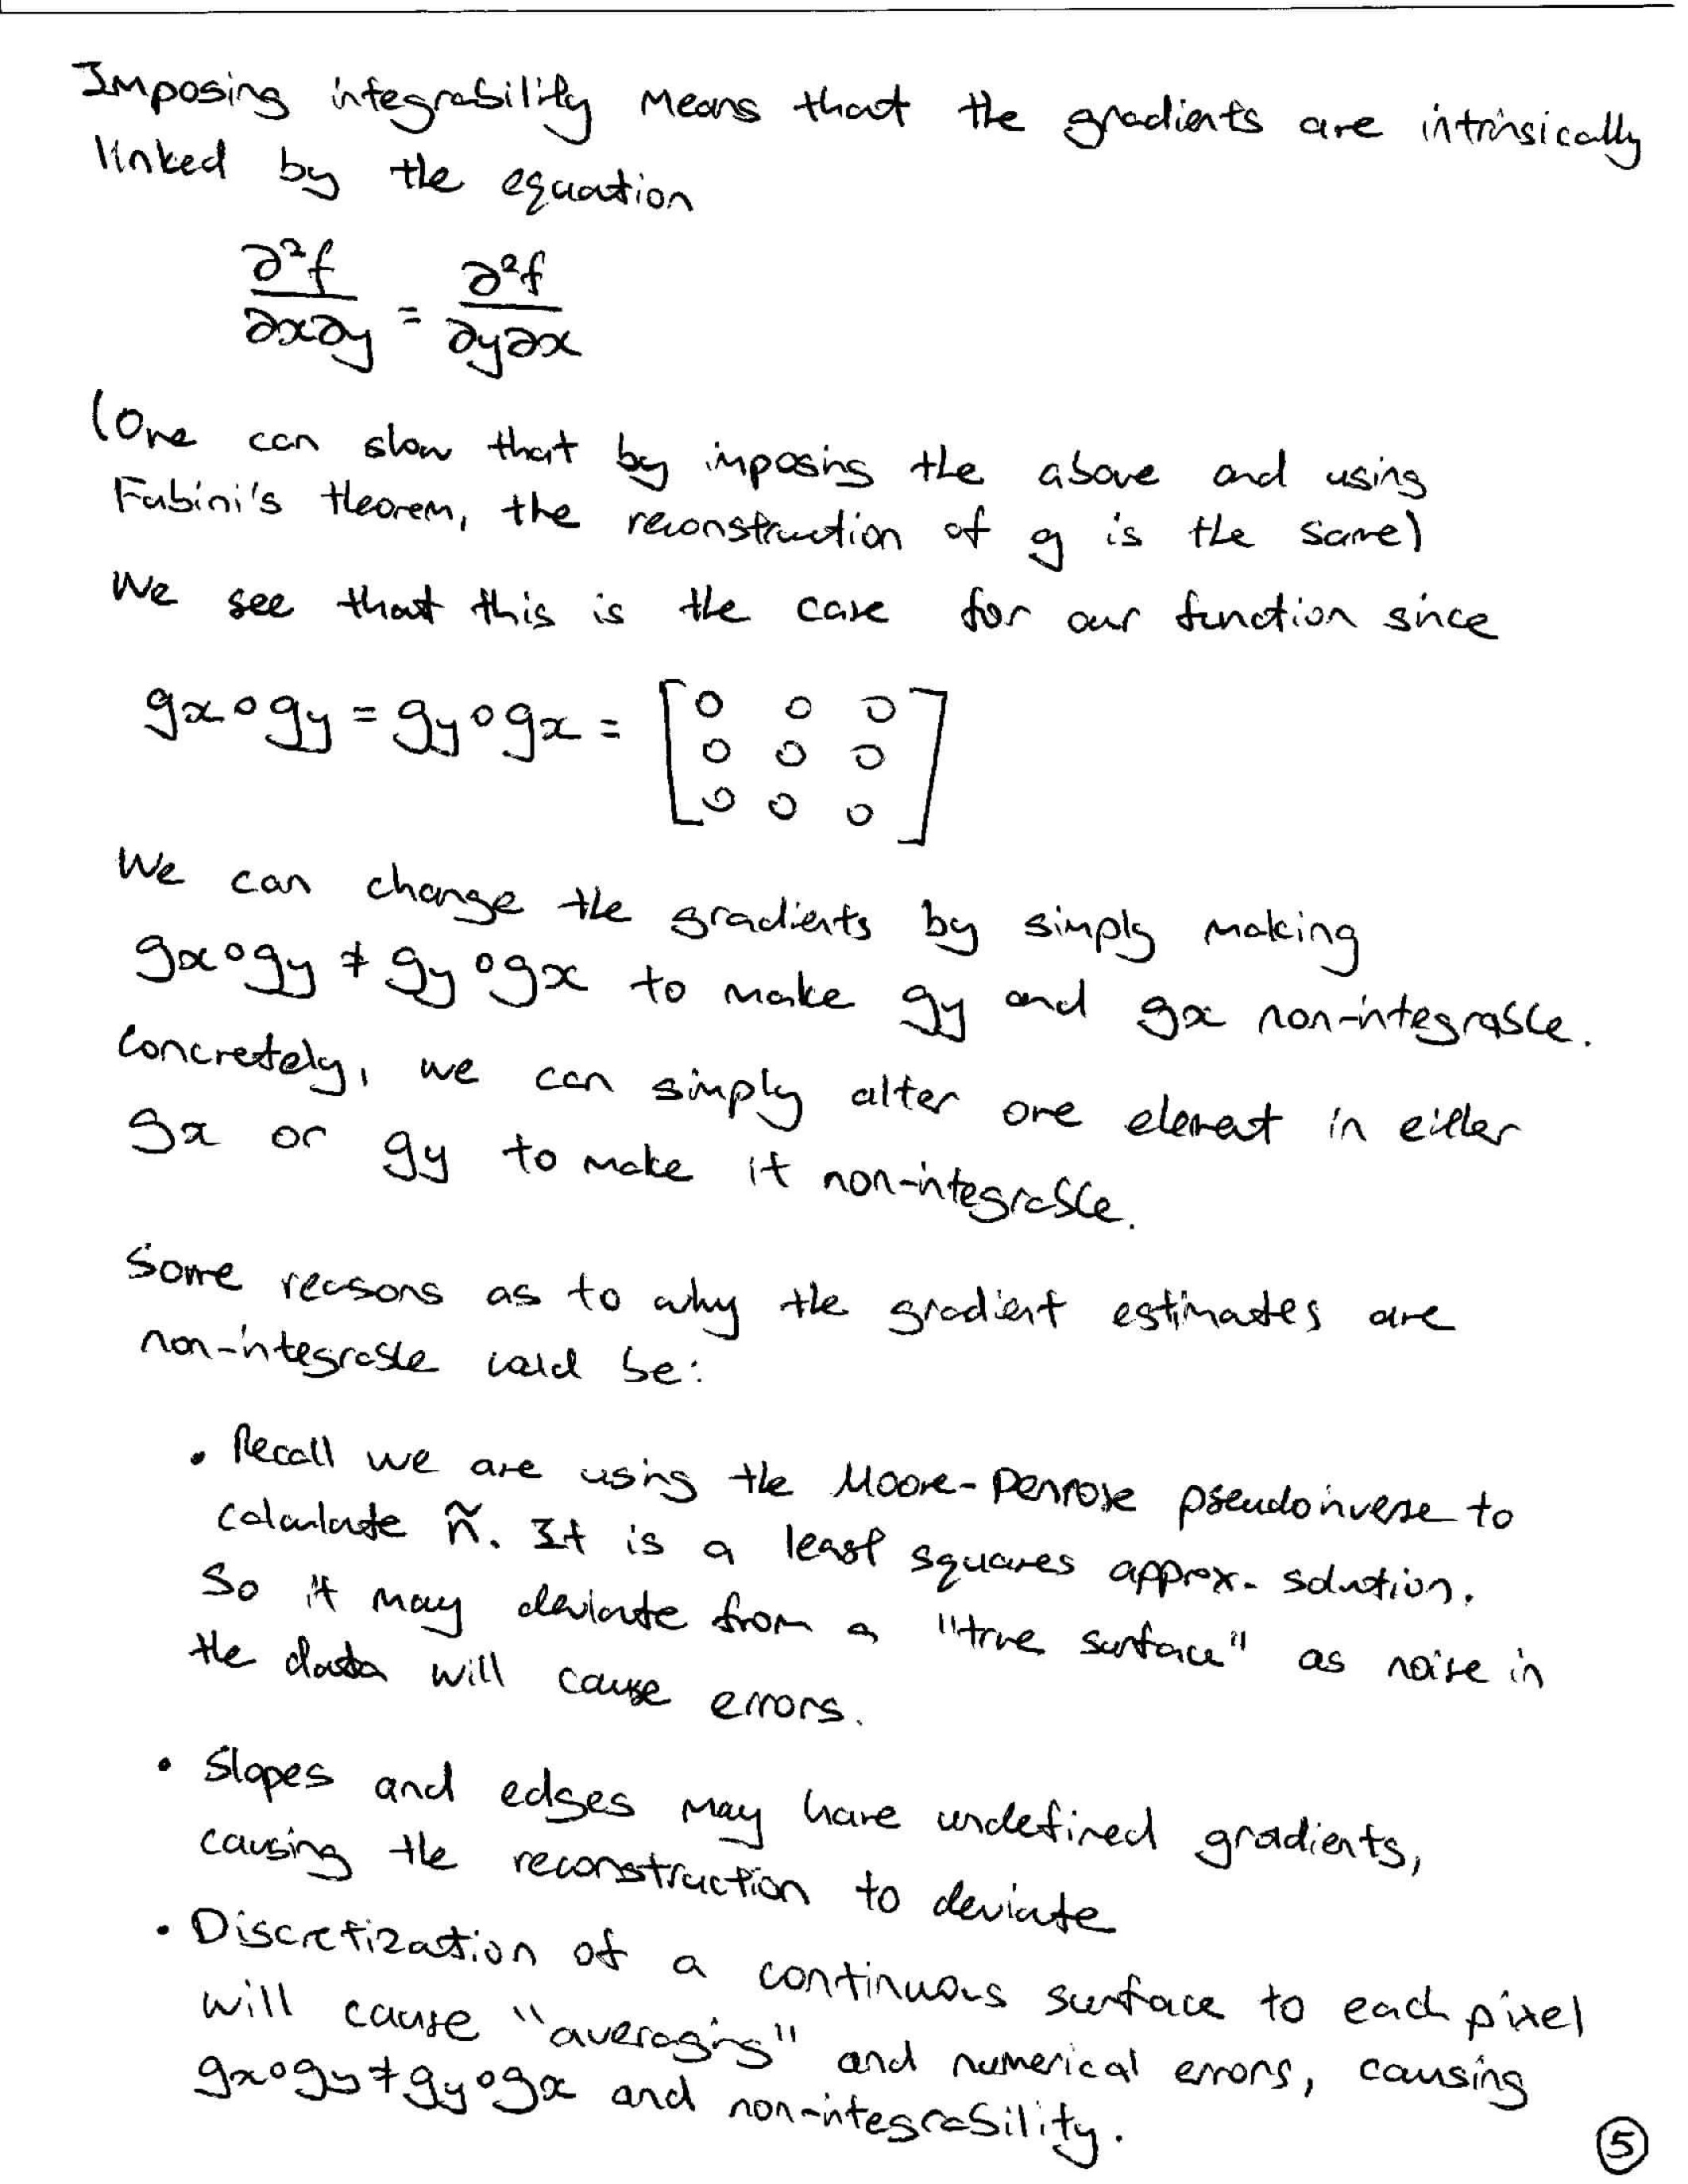

---

### Q 1 (h): Shape estimation (10 points)

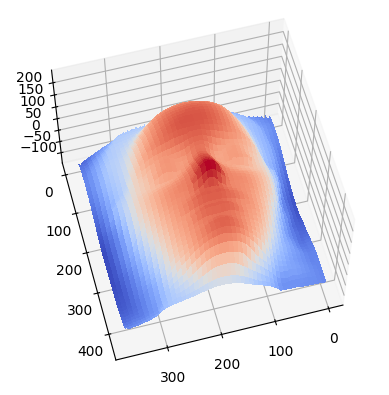

In [ ]:
def estimateShape(normals, s):

    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None

    ### YOUR CODE HERE
    fx = np.reshape(-normals[0,:] / normals[2,:], s)
    fy = np.reshape(-normals[1,:] / normals[2,:], s)

    surface = integrateFrankot(fx, fy)

    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)

# Q2: Uncalibrated photometric stereo (50 points)

### Q 2 (a): Uncalibrated normal estimation (10 points)

---

Given the requirement that the rank of $\hat{I}=\hat{L^T}\hat{B}$ is of rank 3, we can use SVD to decompose $I$ to get $\hat{I}$ as follows:

1. Decompose $I$ using reduced-form SVD to obtain $UΣV^T$, where $dim(U)=7\times 7$, $dim(Σ)=7\times7$, $dim(V^T)=7\times P$ (assuming $dim(I)=7\times P$ as was the case for Q1).
2. Take the top $3\times 3$ entries in $Σ$ to get $Σ_3$ (this effectively sets all singular values in $\Sigma$ except the first three values to zero).
3. Take the first 3 columns of $U$ to get $U_3$ (which has $dim(U_3)=7\times 3$).
4. Take the first 3 rows of $V^T$ to get $V_3^T$ (which has $dim(V_3^T)=3\times P$).
5. Factorize $\hat{I}$ by identifying $\hat{L^T}=U_3 Σ_3^{1/2}$ and $\hat{B}=Σ_3^{1/2}V_3^T$.

Note that $Σ_3^{1/2}$ exists since it is a diagonal matrix with singular values, and its square root is simply the absolute value of the top 3 eigenvalues of $I$. $dim(\hat{L^T})=7\times 3$ and $dim(\hat{B})=3\times P$ so the dimensions are appropriate for the desired decomposition. Moreover, since $\hat{I}=\hat{L^T}\hat{B}$ is the composition of two matricies with a minimal dimension of 3, the rank of $\hat{I}$ is 3 (the rank can be less than 3, but that would require the matrix $I$ to only have 2 eigenvalues, which corresponds to all incident light sources being aligned in a 2D plane).

---

### Q 2 (b): Calculation and visualization (10 points)

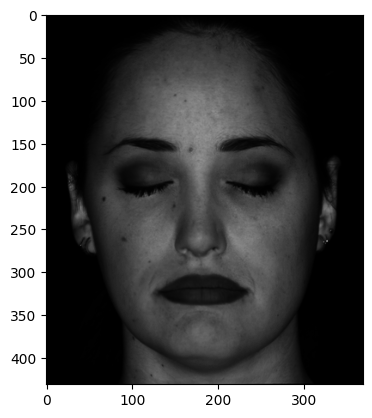

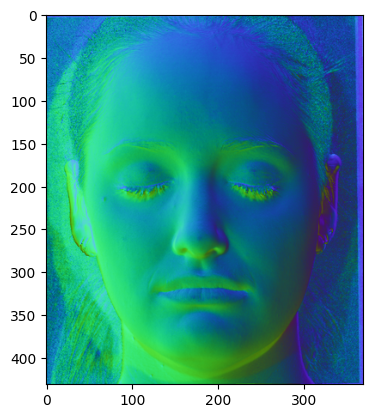

In [ ]:
def estimatePseudonormalsUncalibrated(I):

	"""
	Question 2 (b)

	Estimate pseudonormals without the help of light source directions.

	Parameters
	----------
	I : numpy.ndarray
		The 7 x P matrix of loaded images

	Returns
	-------
	B : numpy.ndarray
		The 3 x P matrix of pesudonormals

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

	"""

	B = None
	L = None
	### YOUR CODE HERE

	U, S, Vt = np.linalg.svd(I, full_matrices=False)

	S[3:] = 0
	S_3 = np.diag(S[:3])
	U_3 = U[:, :3]
	Vt_3 = Vt[:3, :]

	Lt = np.dot(U_3, np.sqrt(S_3))
	B = np.dot(np.sqrt(S_3), Vt_3)
	L = Lt.T

	### END YOUR CODE
	return B, L

# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


### Q 2 (c): Comparing to ground truth lighting

---

Referring to the code below, the ground truth lighting directions and the estimated lighting directions are not similar and differ quite a lot. For a simple change, we could factorize $\hat{L^T}=U_3$ and $\hat{B}=Σ_3V_3^T$. More generally, any factorization such that $\hat{L^T}=U_3 Σ_3^{\alpha}$ and $\hat{B}=Σ_3^{1-\alpha}V_3^T$ with $\alpha \in [0, 1]$ will produce the same rendered image since $\hat{I}=\hat{L^T}\hat{B} = U_3 Σ_3^{\alpha}Σ_3^{1-\alpha}V_3^T = U_3Σ_3V_3^T$ for any $\alpha \in [0, 1]$.

---


In [ ]:
print("Ground truth lighting directions:")
print(L)
print("Estimated lighting directions:")
print(LEst)

Ground truth lighting directions:
[[-0.1418  0.1215 -0.069   0.067  -0.1627  0.      0.1478]
 [-0.1804 -0.2026 -0.0345 -0.0402  0.122   0.1194  0.1209]
 [-0.9267 -0.9717 -0.838  -0.9772 -0.979  -0.9648 -0.9713]]
Estimated lighting directions:
[[-2.99267472 -3.86998525 -2.40803005 -3.74500806 -3.59135539 -3.38666635
  -3.3525448 ]
 [ 0.94780484 -2.31708946  0.49911094 -0.62599426  2.32568155  0.46605103
  -0.79271078]
 [ 1.87934697  1.01461663  0.42942606 -0.01730299 -0.3107729  -0.91273581
  -1.8830081 ]]


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

Looking at the 3D depth map below, it obviously does not look like a face.

---

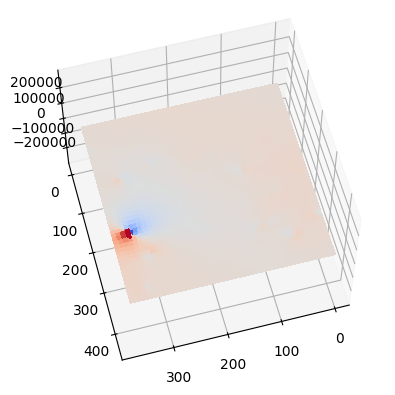

In [ ]:
# Part 2 (d)
### YOUR CODE HERE

surface = estimateShape(normals, s)
plotSurface(surface)

### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

Yes, this surface looks much better and more like the output from the calibrated photometric stereo.

---


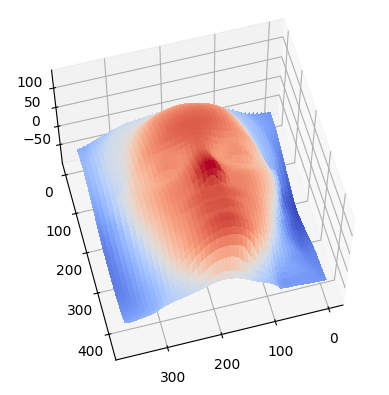

In [ ]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE

B_t = enforceIntegrability(B, s)
albedos_t, normals_t = estimateAlbedosNormals(B_t)
surface_t = estimateShape(normals_t, s)
plotSurface(surface_t)

### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

The term bas-relief ambiguity is so named because different surfaces can appear identical when viewed under different lighting (but the surface and lighting change needs to be a related by applying the same transformation and its inverse). For example, we can transform the normals (i.e. shape) by $G^{-T}$ while simutaneously transform the lighting by $G$ to give us the same image intensities. This introduces an ambiguity in the shape from the uncalibrated photometric stereo (which has 3 DOF).

The $\lambda$ value scales the depth of the image. A higher $\lambda$ makes the surface appear steeper and elongated, while a lower $\lambda$ makes the surface depth become flattened and shallow. A negative value flips the depth to make it "inside out".

The $\mu$ value tilts the surface along the x-direction. A high (positive) value tilts it so the left side is lower, a high (negative) value tilts it so the right side is lower. A low value does not tilt the surface so much. The surface also becomes stretched along the x-axis.

The $\nu$ value tilts the surface along the y-direction. A high (positive) value tilts it so the bottom side is lower, a high (negative) value tilts it so the top side is lower. A low value does not tilt the surface so much. The surface also becomes stretched along the y-axis.

Mathematically, what the bas-relief parameters are doing is the following: $z=\lambda f(x,y)+\mu x + \nu y$, where $f(x,y)$ is the "true" surface. The $\lambda$ value scales the depth of the image, while the $\mu$ and $\nu$ values adds a tilting plane to the z-values and shifts the surface by that plane.

---

<IPython.core.display.Javascript object>

mu=0.0, nu=0, lam=1


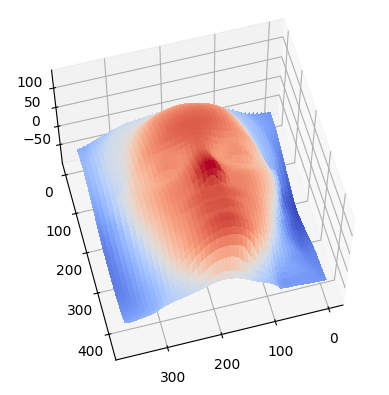

mu=0.5, nu=0, lam=1


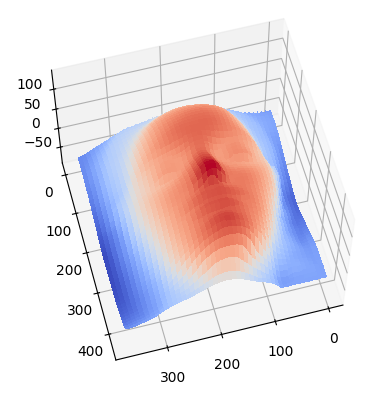

mu=5.0, nu=0, lam=1


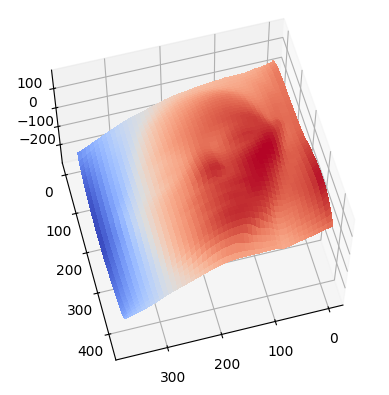

mu=-5.0, nu=0, lam=1


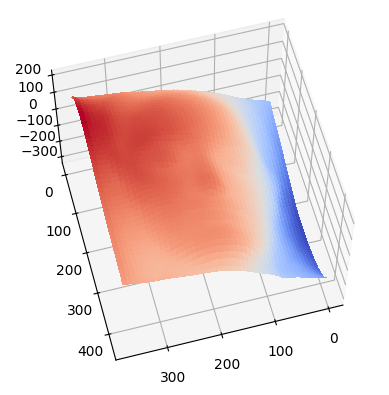

mu=0, nu=0.0, lam=1


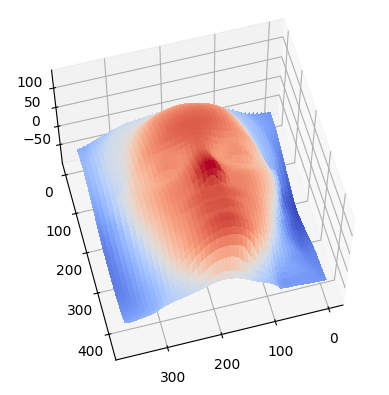

mu=0, nu=0.5, lam=1


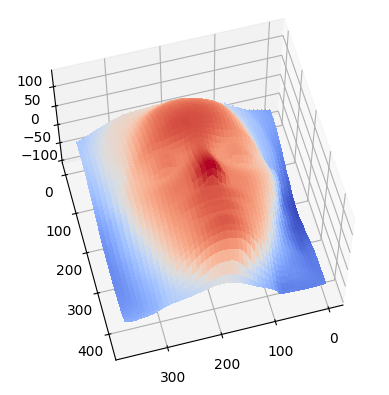

mu=0, nu=5.0, lam=1


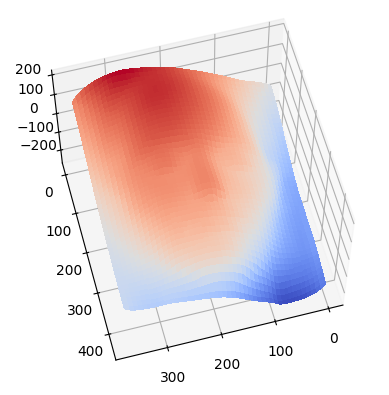

mu=0, nu=-5.0, lam=1


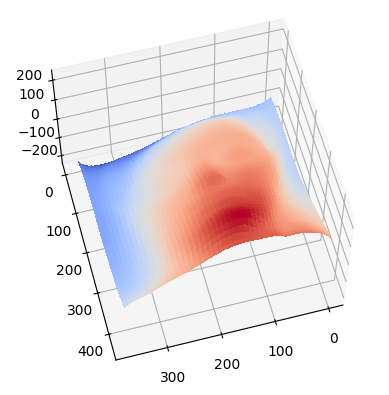

mu=0, nu=0, lam=1.0


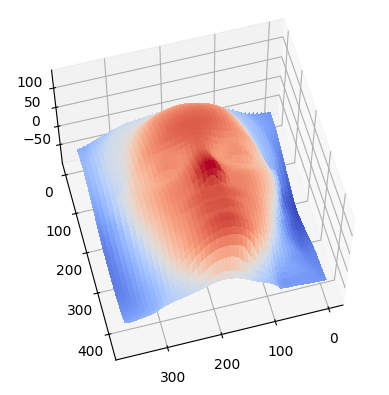

mu=0, nu=0, lam=0.5


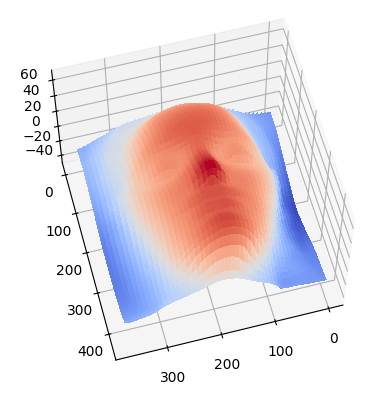

mu=0, nu=0, lam=5.0


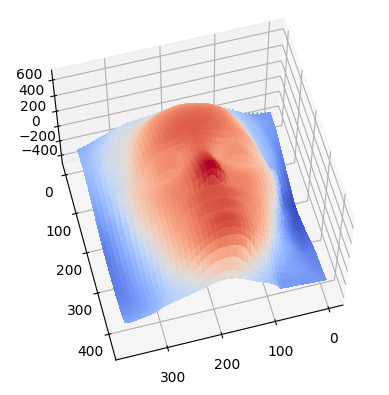

mu=0, nu=0, lam=-1.0


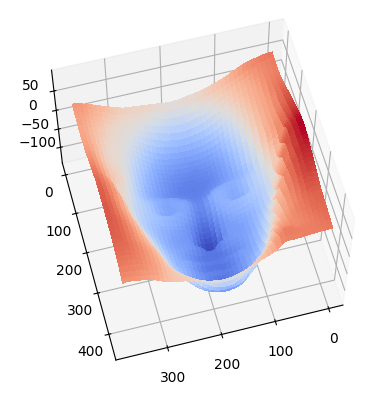

In [ ]:
def plotBasRelief(B, mu, nu, lam):

    """
    Question 2 (f)

    Make a 3D plot of of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    P = np.asarray([[1, 0, -mu/lam],
					[0, 1, -nu/lam],
					[0, 0,   1/lam]])
    Bp = P.dot(B)
    surface = estimateShape(Bp, s)
    print(f'mu={mu}, nu={nu}, lam={lam}')
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# keep all outputs visible
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Part 2 (f)
### YOUR CODE HERE

nu = 0
lam = 1
mu_values = [0.0, 0.5, 5.0, -5.0]
for mu in mu_values:
	plotBasRelief(B_t, mu, nu, lam)

mu = 0
lam = 1
nu_values = [0.0, 0.5, 5.0, -5.0]
for nu in nu_values:
	plotBasRelief(B_t, mu, nu, lam)

mu = 0
nu = 0
lam_values = [1.0, 0.5, 5.0, -1.0]
for lam in lam_values:
	plotBasRelief(B_t, mu, nu, lam)

### END YOUR CODE

### Q 2 (g): Flattest surface possible (5 points)

---

Theoretically, we could set $\lambda$ to be as close to zero as possible to make the surface as flat as possible. Note that $\lambda$ cannot equal zero as then $G$ would not be invertible. The $\mu$ and $\nu$ values do not matter too much as they as simply shifting the flattened surface by a plane.

Using $\lambda = 10^{-5}$, we obtain the following plots below (note the z-axis is in decimals). For non-zero $\mu$ and $\nu$, we see that the surface is flat relative to the tilted plane they are on.

---

mu=0, nu=0, lam=0.0001


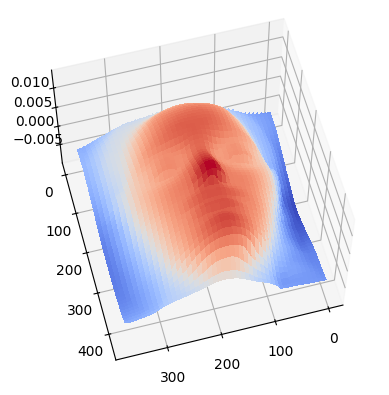

mu=1, nu=0, lam=0.0001


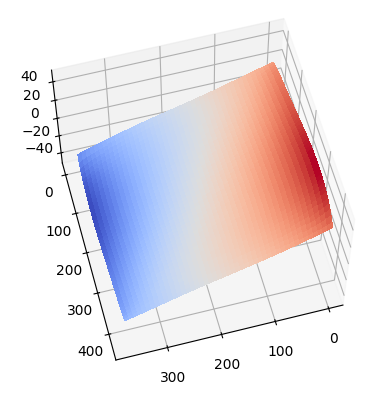

In [ ]:
nu = 0
mu = 0
lam = 10e-5
plotBasRelief(B_t, mu, nu, lam)

nu = 0
mu = 1
lam = 10e-5
plotBasRelief(B_t, mu, nu, lam)

### Q 2 (h): More measurements

---

No. Acquiring more pictures from more lighting directions will not resolve the ambiguity. This is because of the way we are decomposing the image intensities ($I$ vector) into its component $L^T$ and $B$ vectors. Since we are using SVD to do it, we decompose $I$ to $U_3 Σ_3 V_3^T$, where $dim(U_3)=N\times 3$ ($N$ is the number of light sources), $dim(Σ_3)=3\times 3$, $dim(V_3^T)=3\times P$. Absorbing $Σ_3$ into either $U_3$ or $V_3^T$, we can always slot an invertible $3\times 3$ matrix $G$ and its inverse $G^{-1}$ into the middle of $U_3$ and $V_3^T$ and still get the same image intensity $I$, no matter what $N$ you choose. If additionally imposing integrability, the matrix $A$ can be proven to have 3 degrees of freedom, corresponding physically to ambiguities in steepness, and the tilt of the plane the surface is on (i.e. we can transform all the lights by $G$ and do the inverse transform by $G^{-1}$ on the surface, then the image is the same).

---